# Инструменты для работы с языком

В этом семинаре мы познакомимся с задачей классификации текста. Научимся представлять слова из естественной речи в информативном и удобном для обучения моделей виде.

## Почему вам будет полезен этот семинар:
1. Познакомитесь с предобработкой текстовых данных
2. Узнаете про векторные представления слов
3. Построите модель для классификации текстов

## Задача: классификация твитов по тональности

В нашем распоряжении находится датасет из твитов, для каждого из которых определена эмоциональная тональность: положительная или отрицательная. Наша задача - разработать модель машинного обучения, которая на основе текста твита классифицирует его эмоциональную окраску.

Классификация эмоциональной тональности используется в системах рекомендаций для оценки восприятия пользователем различных услуг и продуктов, таких как кафе, кино и прочее. Это позволяет более точно понимать предпочтения пользователей и улучшать качество предоставляемых рекомендаций.

Скачиваем выборку: [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [71]:
!pip install numpy==1.26.4

# **!!!ОБЯЗАТЕЛЬНО ПЕРЕЗАПУСТИТЬ СЕАНС!!!**

Сделаем проверку версии

In [1]:
import numpy

In [2]:
numpy.__version__

'1.26.4'

In [3]:
!pip install gensim

In [4]:
!wget -O tweeter.csv https://www.dropbox.com/scl/fi/u6gvo2t0ehlnwho5la45p/tweeter.csv?rlkey=tebhp39fibmmpaqk0rfyvs4ws&dl=0https://www.dropbox.com/scl/fi/u6gvo2t0ehlnwho5la45p/tweeter.csv?rlkey=tebhp39fibmmpaqk0rfyvs4ws&dl=0

--2025-05-20 09:34:59--  https://www.dropbox.com/scl/fi/u6gvo2t0ehlnwho5la45p/tweeter.csv?rlkey=tebhp39fibmmpaqk0rfyvs4ws
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb92fb7adaf980d4cc5a001a713.dl.dropboxusercontent.com/cd/0/inline/CqA9f0NiYjRmrCSQiU91bOH0ibo_vtS0hAQeSBCKJx_cZ5AC6-ixnKX2YqKfz_dNgAFtyTJYTHwknsBoOXKfKYY3Nwx3O68fRompaALLrH3uLaZQnYQ9gaN0Nn_yqqmneu2P_aPX65sniAUNIKvLBqda/file# [following]
--2025-05-20 09:34:59--  https://ucb92fb7adaf980d4cc5a001a713.dl.dropboxusercontent.com/cd/0/inline/CqA9f0NiYjRmrCSQiU91bOH0ibo_vtS0hAQeSBCKJx_cZ5AC6-ixnKX2YqKfz_dNgAFtyTJYTHwknsBoOXKfKYY3Nwx3O68fRompaALLrH3uLaZQnYQ9gaN0Nn_yqqmneu2P_aPX65sniAUNIKvLBqda/file
Resolving ucb92fb7adaf980d4cc5a001a713.dl.dropboxusercontent.com (ucb92fb7adaf980d4cc5a001a713.dl.dropboxusercontent.com)... 162.125.5.15, 2620:10

In [5]:
import re

import pandas as pd # Библиотека для удобной работы с датафреймами
import numpy as np # Библиотека для удобной работы со списками и матрицами

# Библиотека, в которой реализованы основные алгоритмы машинного обучения
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)
np.random.seed(42)

Загрузим файлы и сформируем структуру данных DataFrame, которая будет содержать тексты твитов и соответствующие им метки.  

In [6]:
# Загружаем данные
df = pd.read_csv('tweeter.csv')

Посмотрим на полученные данные:

In [7]:
df.sample(8, random_state=31)

,text,label
31228,"@tomllins так долго?Луиша,ну ты чего?(( лечись...",negative
168745,"@lizaza33 перестань обрабатывать так фотки,в к...",positive
13324,@_Mahira_ ну как интересно? у нас тоже в шк п...,negative
151782,"@vestal_cr У меня тоже не открывается, даже уз...",negative
177792,@alekorotkova1 да у нас такая же( ты кстати не...,negative
206276,"У меня такое прекрасное настроение, что сама ш...",positive
48030,"А когда я пыталась перепрыгнуть яму,чтобы засн...",positive
116521,RT @winteat: @Pravodumru Я же чувствую)@veraur...,positive


## Предобработка текста

Перед классификаций текста принято выполнять несколько основных шагов обработки текста:
 - очистка текстов
 - токенизация
 - векторизация

 Поговорим вначале про ***очистку текстов.***

 В `df.sample()` видно, что в наших твитах встречаются некоторые лишние символы и слова.

  1. Удаление стоп-слов и знаков пунктуации
     
     **Стоп-слова** представляют собой слова, которые встречаются в тексте чрезвычайно часто, но при этом не несут значимой информации о специфике документа. Для аналитической модели такие слова являются лишь шумом, от которого предпочтительно избавиться. Такая же логика применима к знакам пунктуации – они также удаляются для уменьшения нерелевантных данных.

  2. Лемматизация

    **Лемматизация** – это процесс приведения различных форм слова к его базовой форме - лемме. Почему это важно?

    *Во-первых*, это позволяет рассматривать каждое слово как уникальный признак, не разделяя его на различные грамматические формы.

    *Во-вторых*, в словаре стоп-слов многие слова хранятся только в их начальной форме, и без процесса лемматизации мы можем упускать другие вариации стоп-слов.
  
Вместо лемматизации можно использовать **стемминг**. Он также приводит слова к их базовой форме, но путем удаления окончания, суффикса, и приставки. В результате может получиться несуществующее слово. При этом стемминг удаляет важную информацию о форме слова, например, глагольное окончание. Для русского языка, с его множеством различных форм слов, это является серьезным недостатком. Посмотрим на сравнение лемматизации и стемминга для предложения 'Коты играют в саду'

Лемматизация:
`кот играть в сад`

Стемминг:
`кот игра в сад`

Все стоп-слова для русского языка можно получить в библиотеке `nltk` (Natural Language ToolKit) в `stopwords`.
Для знаков пунктуации есть модуль `string`, в котором также можно получить массив со всеми знаками пунктуации.

In [8]:
import nltk

# Загружаем нужные данные
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Импортируем стоп-слова из библиотеки nltk
from nltk.corpus import stopwords

# Посмотрим на стоп-слова русского языка
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [10]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Для лемматизации русских предложений есть  библиотека [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)

In [11]:
# Устанавливаем pymorphy3
!pip install pymorphy3

В Pymorphy3 для морфологического анализа слов есть ```MorphAnalyzer()```:

In [12]:
from pymorphy3 import MorphAnalyzer
pymorphy3_analyzer = MorphAnalyzer()

Pymorphy3 предназначен для работы с отдельными словами. Если на вход подать целое предложение, он не выполнит лемматизацию, поскольку не распознает его структуру.

In [13]:
sent = 'Если б мне платили каждый раз'.split()
sent

['Если', 'б', 'мне', 'платили', 'каждый', 'раз']

Лемматизируем слово "платили" из предложения ```sent``` с помощью метода ```parse()```:

In [14]:
analyzer = pymorphy3_analyzer.parse(sent[3])
analyzer

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2471, 10),))]

Выведем его нормальную форму:

In [15]:
analyzer[0].normal_form

'платить'

Создадим три функции, для полной предобработки текстов. Поскольку твитов у нас много, дополнительно импортируем библиотеку `tqdm`, для отображения статуса обработки.

In [16]:
from tqdm import tqdm_notebook as tqdm

In [17]:
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")
morph = MorphAnalyzer()
stop_words_list = stopwords.words('russian')

# Лемматизирует 1 слово
def lemmatize(word, pymorphy=morph):
    try:
        return pymorphy.parse(word)[0].normal_form
    except:
        return None

# Обрабатывает предложение, лемматизируя и удаляя лишние символы
def process_text(text):
    words = regex.findall(text)
    lemmas = [lemmatize(word) for word in words if word not in stop_words_list]
    return " ".join(lemmas)

# Обрабатывает все твиты и создает столбец 'lemmas'
def full_preprocess(df):
    lemmas = [process_text(text) for text in tqdm(df['text'])]
    df['lemmas'] = lemmas
    return df

df = full_preprocess(df)
df.head()

  0%|          | 0/226834 [00:00<?, ?it/s]

,text,label,lemmas
0,"RT @ivanova231297: Еле встала, не хочу никуда ...",negative,rt ivanova : еле встать хотеть никуда идти(((((
1,"Даша негде отмечать Новый Год, Даша в печали:(",negative,даша негде отмечать новый год даша печали:(
2,"@guylove1d добра новому читателю, спасибо что ...",positive,guylove d добро новый читатель спасибо читаешь)
3,"@Sofitem представляешь, не взяли :( придется с...",negative,sofitem представлять взять :( прийтись сам при...
4,"RT @piemstd: колфи, уолкер и комар тож попали ...",negative,rt piemstd: колфи уолкер комар тож попасть гру...


Всего в нашем наборе данных 226 834 твитов. Для получения высокого качества достаточно намного меньшего числа. Выберем 40 000 случайных значений

In [18]:
df_sample = df.sample(40_000, random_state=42)

### Задание 1: Разбейте на обучающую и тестовую выборку

Разбиваем `df_sample` на обучающую и тестовую выборки с помощью функции ```train_test_split()``` из **sklearn**: доля тестовой выборки 0.33, random_state=42.


**Давайте попробуем выполнить данное задание с помощью модели [Giga Chat](https://giga.chat/gigachat/).**

**Промпт:**

Разбить датасет df_sample на обучающую и тестовую выборку с долей тестовой выборки 0.33 и random_state=42. В таблице df_sample "lemmas" - это признаки, а "label" - это соответствующие метки классов. Используй функцию train_test_split() из sklearn. Выполни запрос в одну строчку кода.

In [19]:
### Ваш код ###
# X_train, X_test, y_train, y_test =
### Ваш код ###

# Предположим, что df_sample уже загружен и содержит столбцы "lemmas" и "label"
#X = df_sample["lemmas"]  # Признаки
#y = df_sample["label"]   # Метки классов

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_sample["lemmas"], df_sample["label"], test_size=0.33, random_state=42)

# Выводим размеры полученных выборок
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")


Размер обучающей выборки: 26800
Размер тестовой выборки: 13200


## Токенизация

**Токен** - это минимальная единица текстовой информации, например, как пиксель в картинке. Токеном обычно является слово или часть слова. Токенизация - это разделение текста на токены.

Самый наивный способ токенизировать текст - разделить его с помощью `split()`. Но `split` упускает очень много всего, например, не отделяет пунктуацию от слов. Кроме того, существуют и другие, менее очевидные проблемы, связанные с токенизацией, поэтому предпочтительнее использовать специализированные токенизаторы.

In [20]:
import nltk # Уже знакомая нам библиотека nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize # Готовый токенизатор библиотеки nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Применим токенизацию:

In [21]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

Если использовать просто ```split()```, то грустный смайлик :( не отделяется от слова "исправлять":

In [22]:
example.split()

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять:(']

В nltk есть довольно много токенизаторов:

In [23]:
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'PunktTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer']

**Токенизаторы подбираются под требования задачи!** Например, с помощью токенизаторов можно разбивать слова на слоги или группировать в отдельный токен слова из устойчивых выражений.


## Baseline: классификация необработанных n-грамм

### Векторизаторы

Векторизатор преобразует слово или набор слов в числовой вектор, который можно будет обработать математически и обучить алгоритм машинного обучения работать с таким представлением слов.

Ниже - пример преобразования слов в двумерный вектор, каждому слову соответствует точка на плоскости.


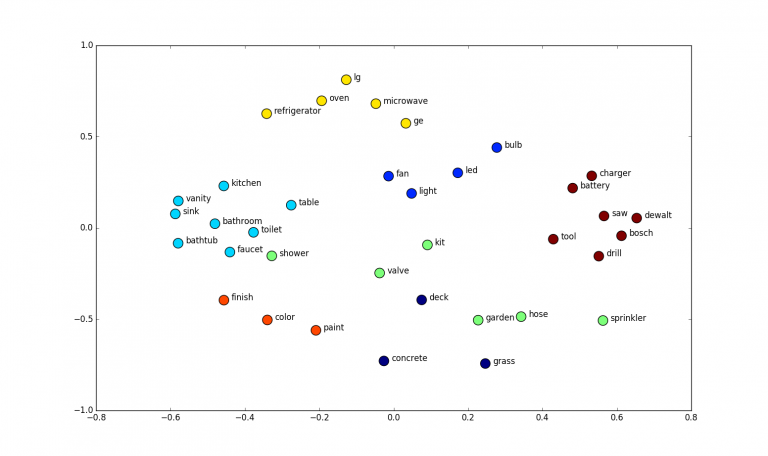

На начальном этапе нам будет достаточно тех инструментов, которые уже есть в знакомой нам библиотеке **sklearn**.

In [31]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer # модель "мешка слов"

## Что такое n-граммы:

Текст может быть представлен **n-граммами** токенов. У n-граммы есть параметр n - количество токенов, которые попадают в такое представление текста.
* Если n = 1 - то мы смотрим на то, сколько раз каждый токен встретился в тексте. Получаем _униграммы_
* Если n = 2 - то мы смотрим на то, сколько раз каждая пара подряд идущих токенов встретилась в тексте. Получаем _биграммы_

Функция для работы с n-граммами реализована в библиотеке **nltk** (Natural Language ToolKit), импортируем эту функцию:

In [24]:
from nltk import ngrams

Прежде чем получать n-граммы, нужно разделить предложение на отдельные слова.  Для этого используем метод ```split()```.

In [25]:
sent = 'Если б мне платили каждый раз'.split()
sent

['Если', 'б', 'мне', 'платили', 'каждый', 'раз']

Чтобы получить n-грамму для такой последовательности, используем функцию ```ngrams()```.

На вход передается два параметра:
* лист с разделенным на отдельные слова предложением (у нас он хранится в переменной ```sent```);
* параметр n, определяющий, какой тип n-грамм мы хотим получить.


Чтобы отобразить полученный объект, делаем из него ```list```.

In [26]:
list(ngrams(sent, 1)) # Униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

Аналогично мы можем получить биграммы - для этого заменяем параметр **n** в функции **ngrams** с 1 на 2.

In [27]:
list(ngrams(sent, 2)) # Биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [28]:
list(ngrams(sent, 3)) # Триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

### Задание 2: Постройте пентаграммы (n=5)

In [29]:
### Ваш код ###
list(ngrams(sent, 5))

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь признаки из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает следующее:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество уникальных слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

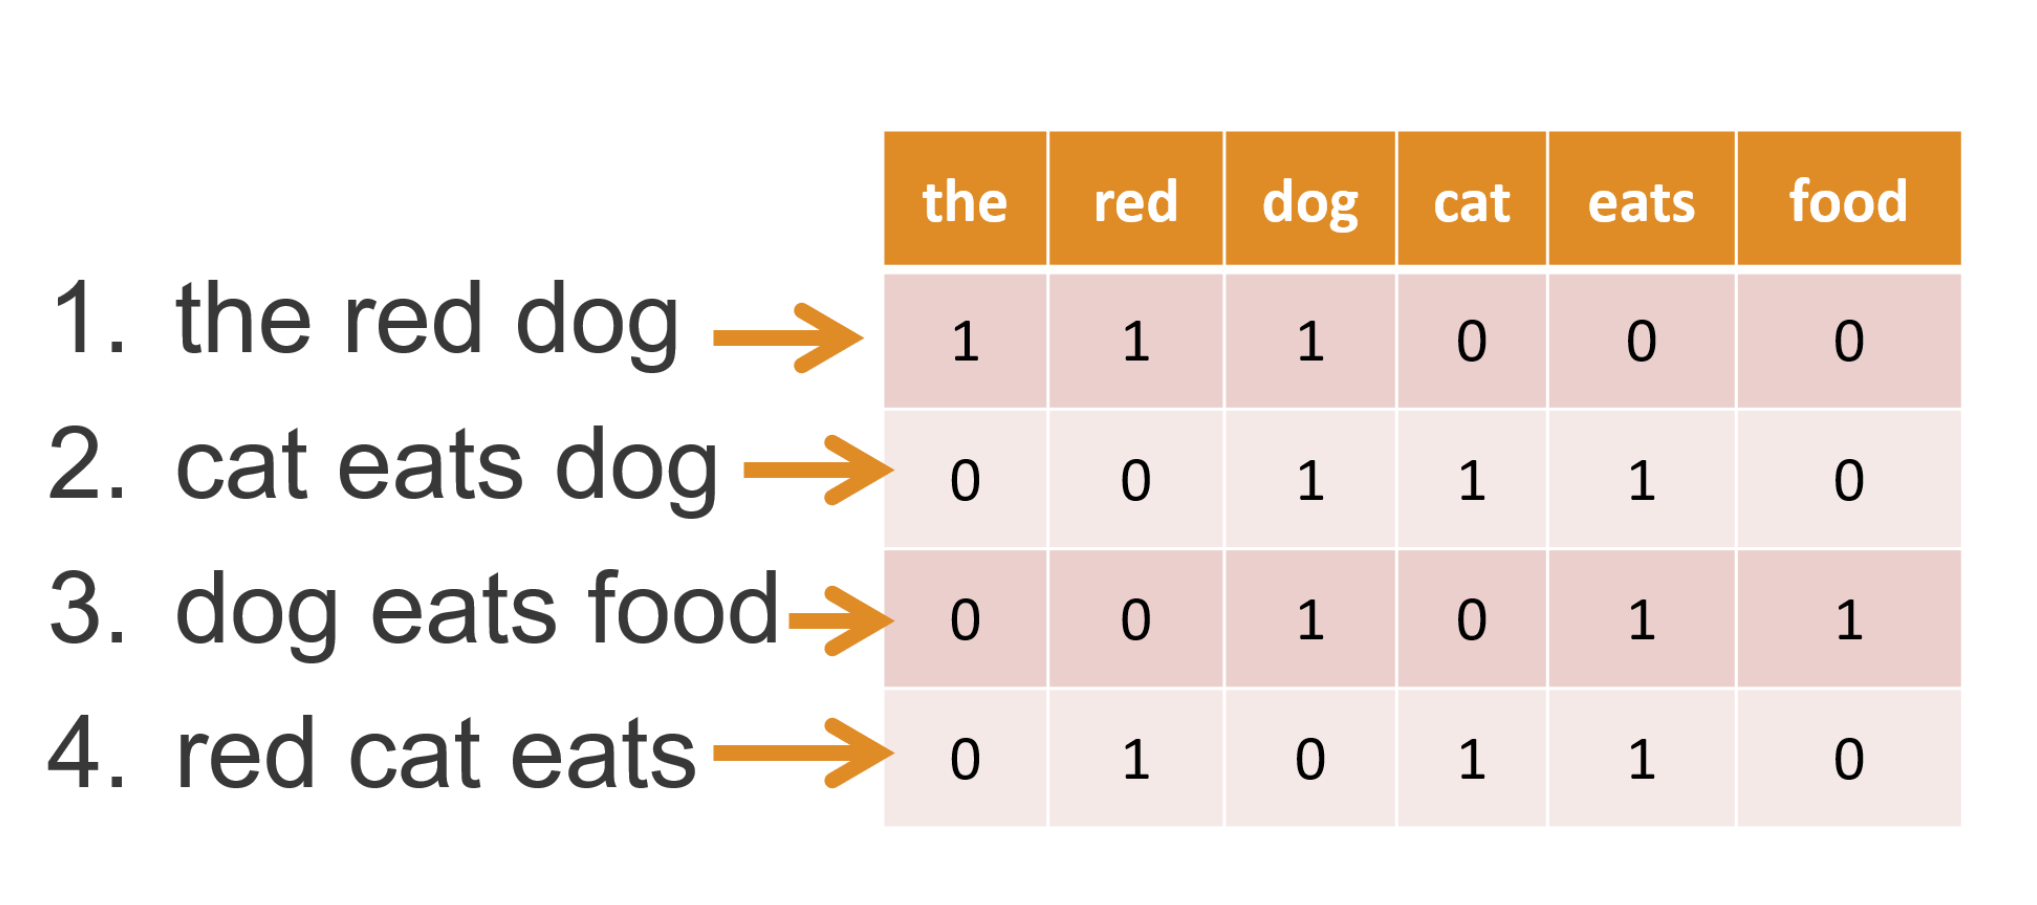

На рисунке пример векторизации для униграмм, но можно использовать любые n-граммы. Для этого у класса ```CountVectorizer()``` есть параметр **ngram_range**, который отвечает за то, какие n-граммы мы используем в качестве признаков:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

Инициализируем ```CountVectorizer()```, указав в качестве признаков униграммы:

In [32]:
vectorizer = CountVectorizer(ngram_range=(1, 1))

После инициализации _vectorizer_ можно обучить на наших данных.

Как обычно, для обучения используем ```X_train```, но в отличие от классификатора мы используем метод ```fit_transform()```: сначала обучаем наш векторизатор, а потом сразу применяем его к нашему набору данных.


In [33]:
vectorized_x_train = vectorizer.fit_transform(X_train)

Поскольку в данной модели не учитывается порядок слов в тексте, используется предположение о том, что текст можно представить в виде "мешка слов". Это значит, что важны только частоты встречаемости слов, а их взаимное расположение в тексте не учитывается.

В vectorizer.vocabulary_ лежит словарь, отображение слов в их индексы:

In [34]:
list(vectorizer.vocabulary_.items())[:10]

[('любить', 34464),
 ('кота', 33158),
 ('sweet', 17608),
 ('home', 7338),
 ('http', 7430),
 ('co', 3494),
 ('db', 4091),
 ('dblit', 4097),
 ('когда', 32600),
 ('рядом', 45972)]

В нашей выборке 26800 текстов (твитов), в них встречается 54738 разных слов.

In [35]:
vectorized_x_train.shape

(26800, 54735)

Так как теперь у нас есть **численное представление** и набор входных признаков, то мы можем обучить модель логистической регрессии (или любую другую из тех, которые мы разобрали ранее на прошлых семинарах)

In [36]:
clf = LogisticRegression(random_state=42) # Фиксируем random_state для воспроизводимости результатов
clf.fit(vectorized_x_train, y_train)

LogisticRegression(random_state=42)

С тестовыми данными нужно проделать то же самое, что и с данными для обучения: сначала векторизировать, а потом подать в модель.

У нас уже есть обученный векторизатор ```vectorizer```, поэтому используем метод ```transform()``` (применить), а не ```fit_transform``` (обучить и применить).

In [37]:
vectorized_x_test = vectorizer.transform(X_test)

Как и раньше, для получения прогноза у обученного классификатора используем метод ```predict()```.

С помощью функции ```classification_report()``` можно теперь посмотреть, насколько хорошо мы предсказываем положительную или отрицательную тональность твита .

In [38]:
pred = clf.predict(vectorized_x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.70      0.71      0.70      6452
    positive       0.72      0.70      0.71      6748

    accuracy                           0.71     13200
   macro avg       0.71      0.71      0.71     13200
weighted avg       0.71      0.71      0.71     13200



In [39]:
clf

LogisticRegression(random_state=42)

Попробуем сделать то же самое, используя в качестве признаков триграммы:

In [40]:
# Инициализируем векторайзер
#trigram_vectorizer = CountVectorizer(ngram_range=(3, 3)) # Результат 0.51 (чуть лучше рандома)
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3)) # Так будет получше чем 3-3

# Обучаем его и сразу применяем к x_train
trigram_vectorized_x_train = trigram_vectorizer.fit_transform(X_train)

# Инициализируем и обучаем классификатор
clf = LogisticRegression(random_state=42)
clf.fit(trigram_vectorized_x_train, y_train)

# Применяем обученный векторайзер к тестовым данным
trigram_vectorized_x_test = trigram_vectorizer.transform(X_test)

# Получаем предсказания и выводим информацию о качестве
pred = clf.predict(trigram_vectorized_x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.69      0.72      0.71      6452
    positive       0.72      0.69      0.71      6748

    accuracy                           0.71     13200
   macro avg       0.71      0.71      0.71     13200
weighted avg       0.71      0.71      0.71     13200



### Вопрос: Как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?

## Embeddings

Модели машинного обучения "видят" данные иначе, чем это делают люди. Они не способны оперировать словами или образами, зато легко взаимодействуют с многомерными векторами из чисел. Если мы хотим передать модели не "число", а, например, текст, то нам необходимо перевести его в понятную модели сущность: числовое представление или **эмбеддинг**.

 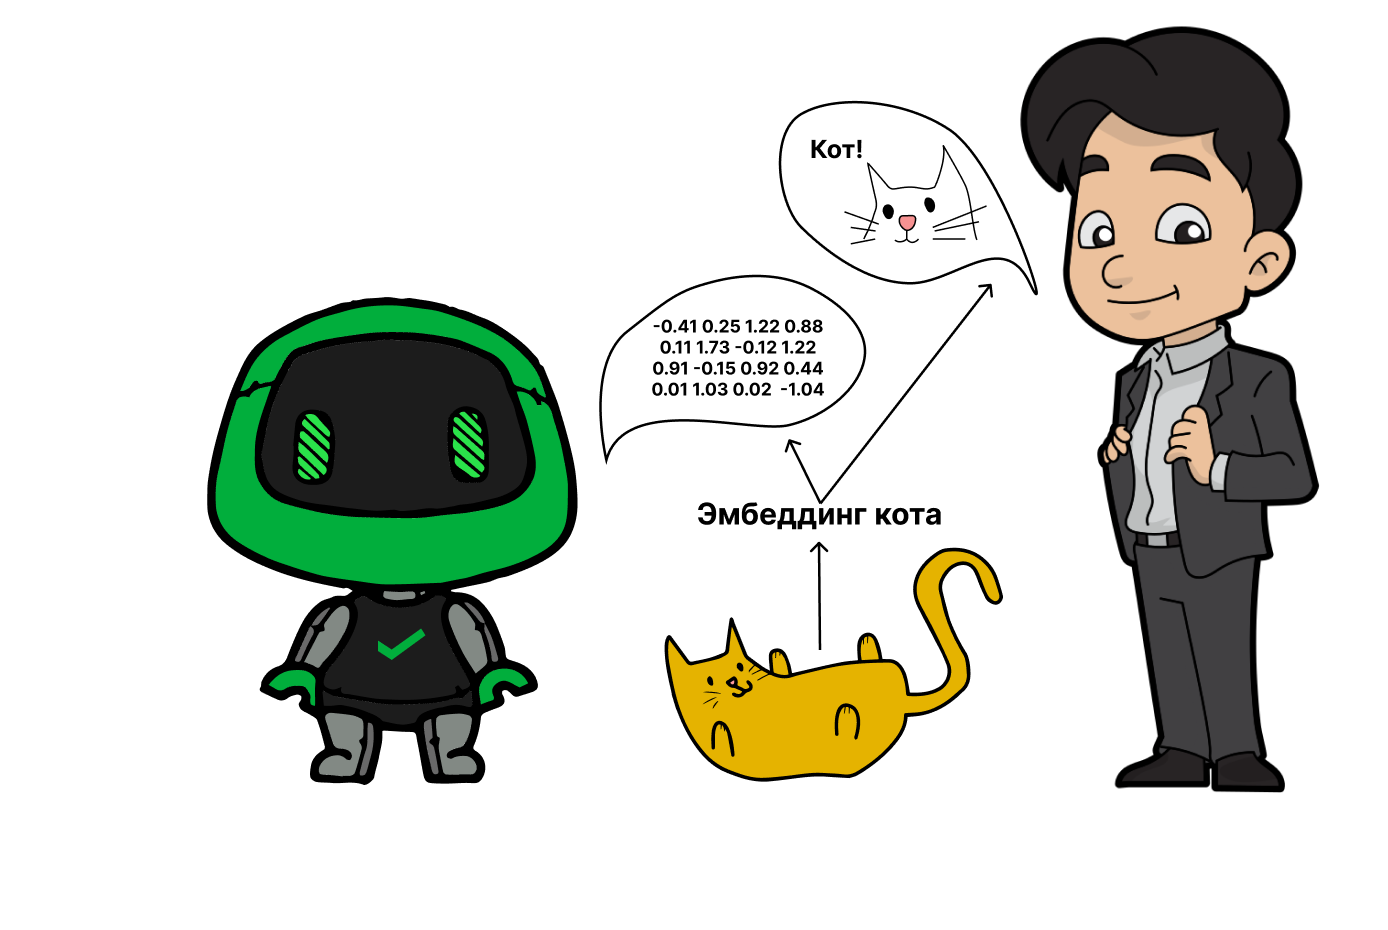

В общем случае, **эмбеддингом называют любое числовое векторное представление объекта**.

* Закодировали слова в числа? Это эмбеддинг!
* Применили обученную нейронную сеть на какие-то данные, чтобы получить полезные признаки (не важно для какой задачи)? Это тоже эмбеддинг.

Чаще всего про эмбеддинги говорят в контексте *моделей машинного обучения для текстов*, так как нам необходимо преобразовать слова/параграфы/текст в числа перед обучением. Кроме того, словесные эмбеддинги (word embeddings) обладают интересными свойствами, возникающими из естественной структуры языка.  

В рамках данного семинара мы остановимся именно на них.

### Как это работает?
Модель для получения **эмбеддингов** принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор.

Векторное представление основывается на *контекстной близости*: слова, встречающиеся в тексте рядом с одинаковыми словами (и предположительно  имеющие схожий смысл), в векторном представлении будут иметь близкие координаты векторов-слов. Для вычисления близости слов используется косинусное расстояние между их векторами.

С помощью моделей эмбеддингов можно получать интересные связи между словами (они же аналогии: А относится к B так же, как C относится к D) и решать примеры:

* *король: мужчина = королева: женщина*
 $\Rightarrow$
* *король - мужчина + женщина = королева*

 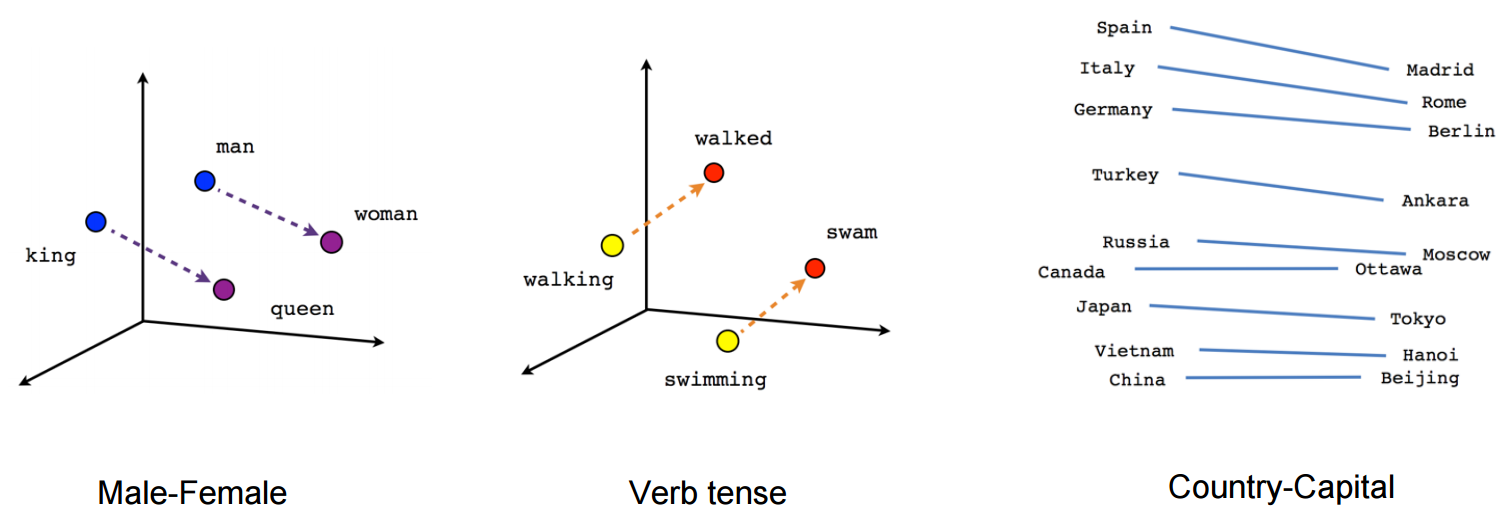

### Как научиться говорить на одном языке с моделью машинного обучения?


 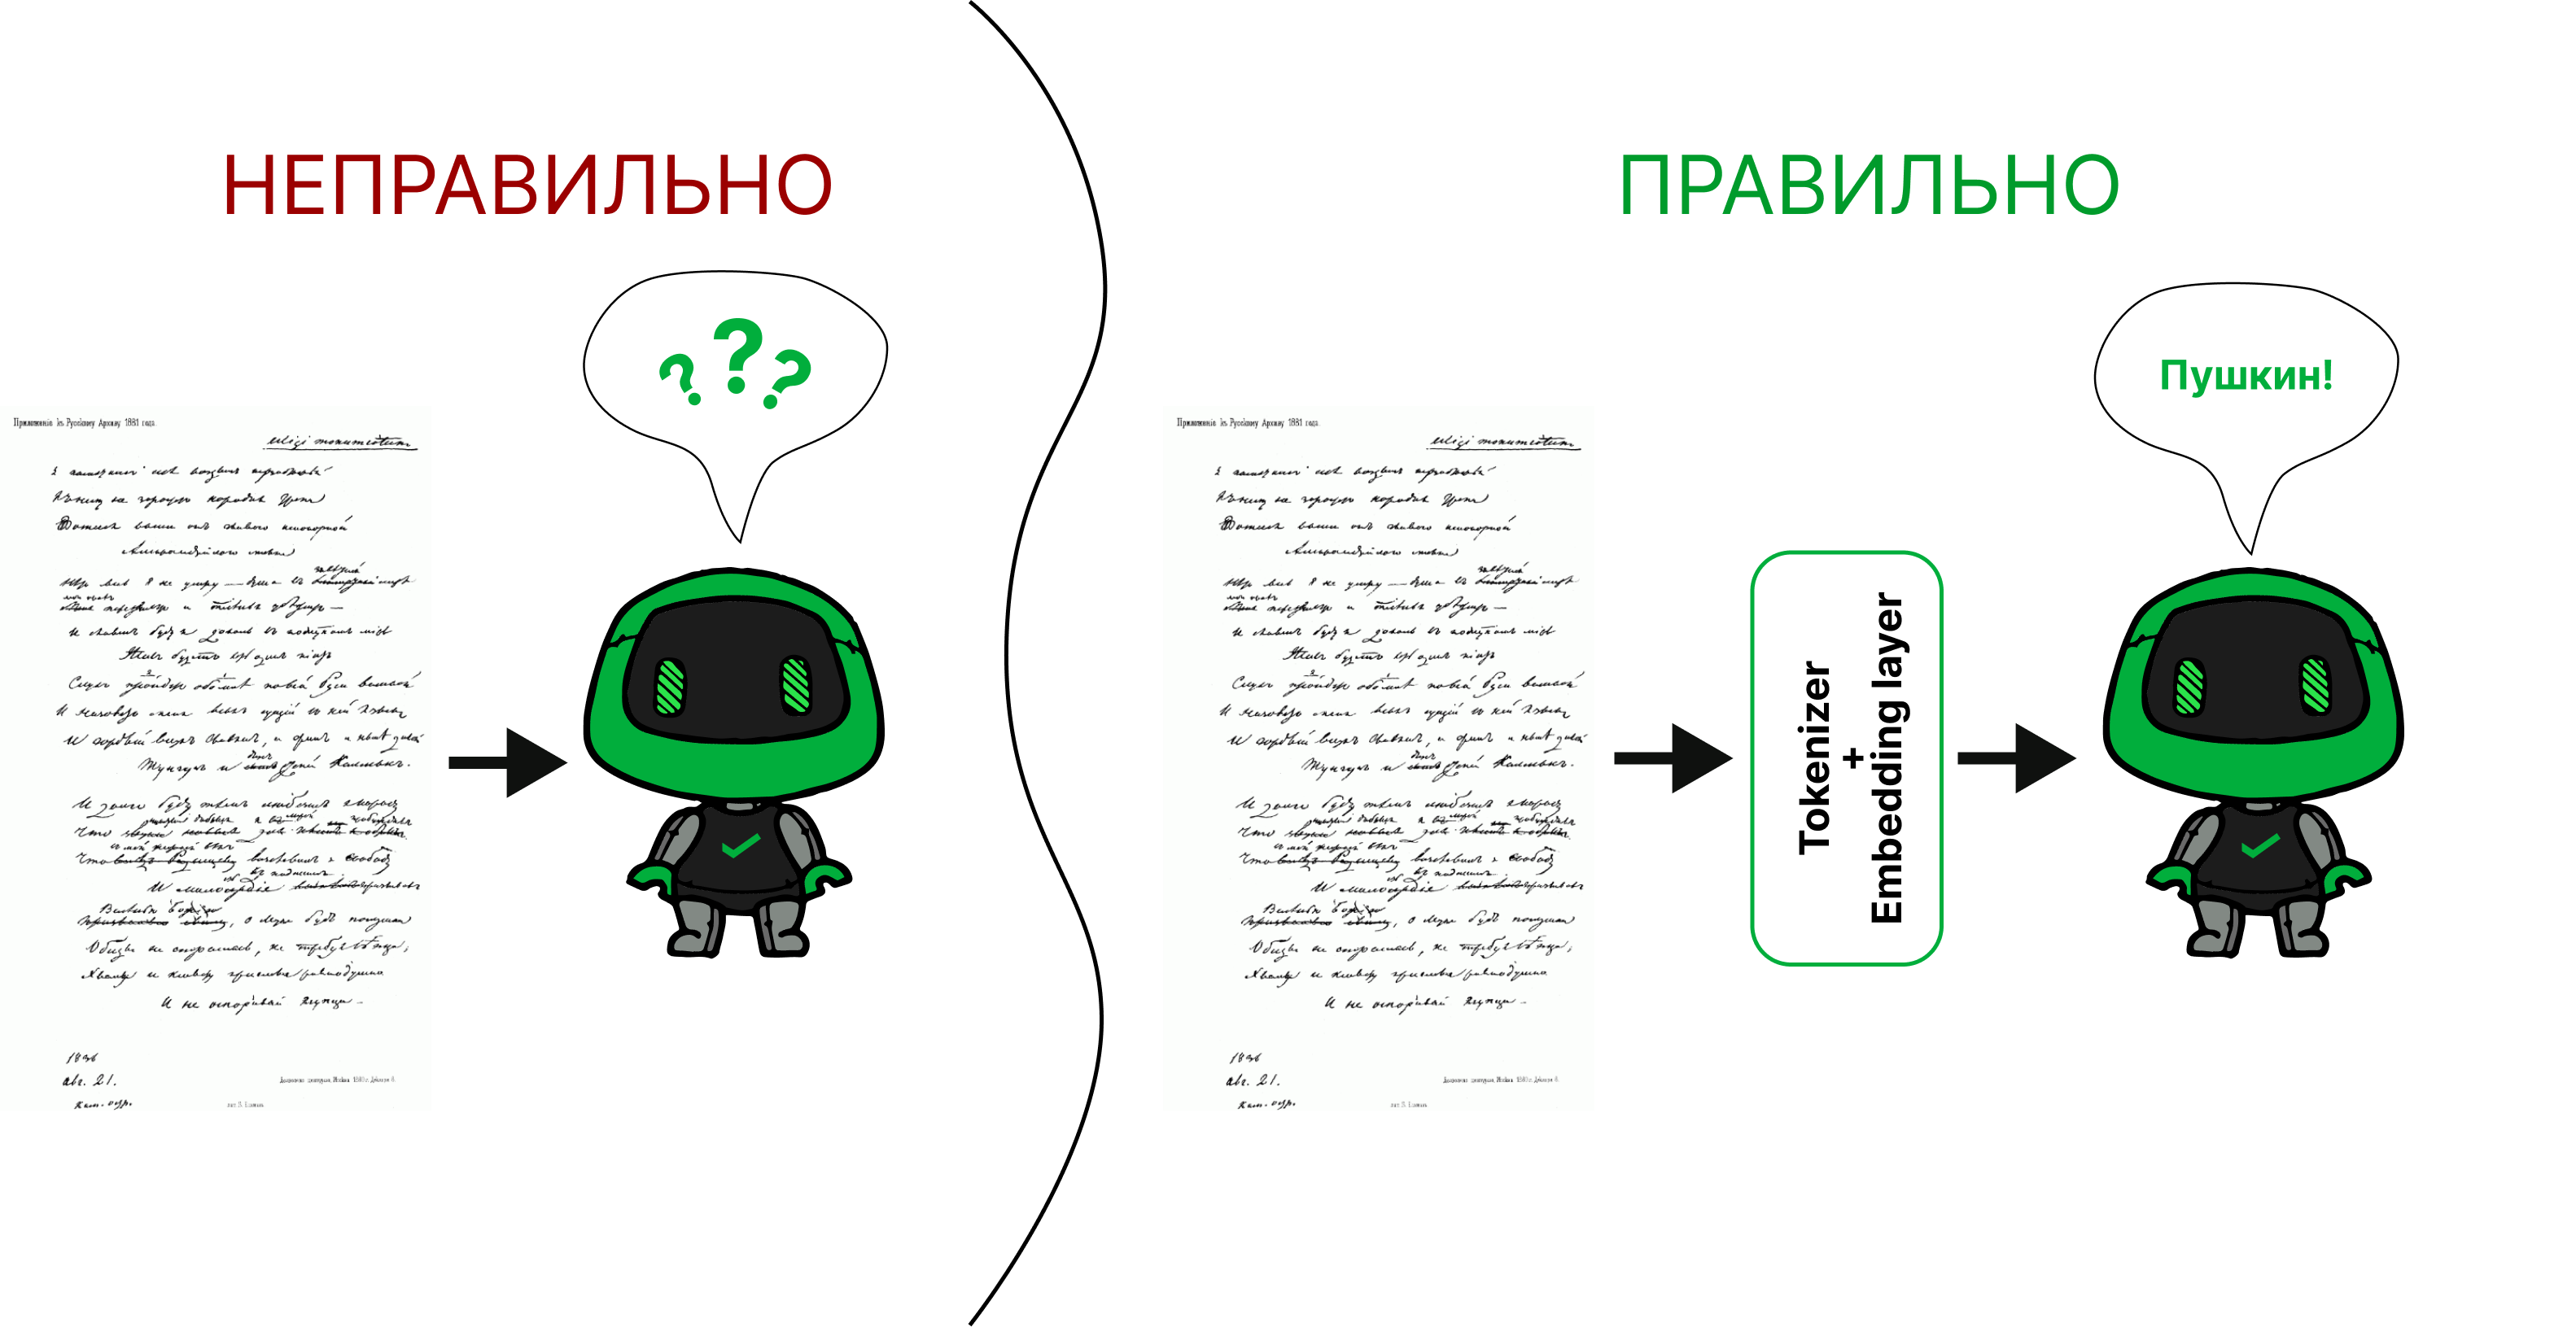

***Как работает Эмбеддинг-слой.***

При работе с токенами-словами, модель для получения эмбеддигов работает со **словарём**. Для каждого слова, **в словаре хранится его числовое представление, эмбеддинг**. Также в словаре обычно выделяется **специальный токен UNK для всех неизвестных слов** и представление для них.

 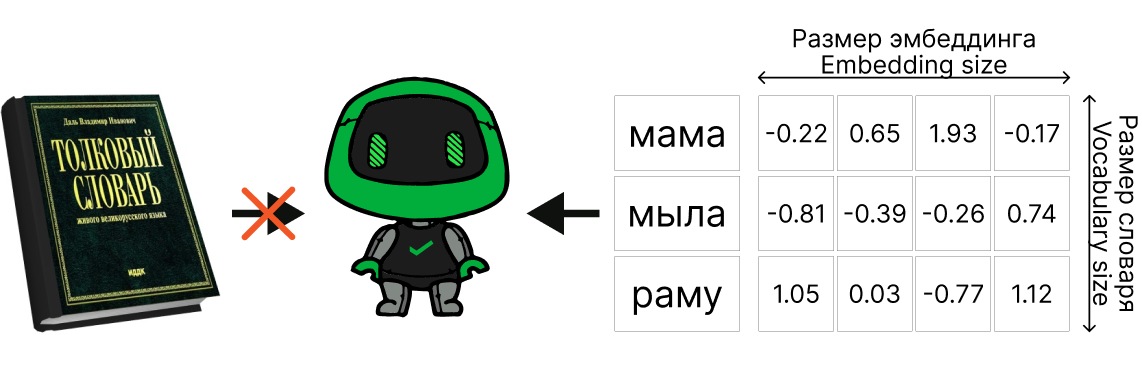

### В чём смысл ... слова?

Логика обучения языковых моделей базируется на следующей идее: **слова, которые часто встречаются в сходных контекстах, имеют сходное значение.**

Итак, представим *слова как многомерные векторы*, где размерность пространства - это размерность эмбеддинга Embedding Size. И будем учить нейросетевую модель *приближать похожие векторы и отдалять непохожие*, согласно контексту.

Так как пространство у нас многомерное, двигаясь вдоль разных осей, мы можем *сопоставлять одному слову сразу несколько* близких по смыслу. Также как и в естественном языке, у одного слова может быть несколько близких ему.

Нейронные сети отлично оперируют с векторами. Нам остается "показать ей", **что такое контекст**.

### NLP база за 5 минут (для интересующихся)

Существует несколько подходов для работы с текстами:

1. Берём корпус текстов и явно считаем статистики по каждому уникальному слову -> например, TF-IDF метод ([sklearn версия](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

Это, скорее, ваш baseline, чем что-то серьёзное. Но для небольших корпусов может сработать.

2. Если мы хотим предсказывать ключевое слово в предложении по его контексту -- слов до него и после него.
Например, возьмем предложение и три слова. По первому и третьему предсказываем второе с помощью модели **Word2Vec**. Дополнительно иногда используют важную вспомогательную технику - Negative sampling, когда "показываем" модели те словосочетания, которые в жизни встречаются редко ("не являются контекстными соседями").
4. **FastText** - одна из самых продвинутых моделей для работы на уровне слов. Комбинирует в себе лучшие техники из Word2Vec, но работает не на уровне слов, а на уровне n-gram символов. Так она может работать с неизвестными ей формами слов.

Минусы - нет информации о предложении, очень мало информации о контексте (1 или 2 слово).
Плюсы - относительная простота и хорошая интерпретируемость. Хотя в моделях явным образом не заложено семантических свойств, оказалось, что Word2Vec (и его преемники) всё же могут улавливать некоторые интересные свойства.

Далее мы сравним два подхода для создания эмбеддингов слов: Word2Vec и FastText

### King + Woman - Man это Queen?

Давайте попробуем визуализировать представления выше и посмотреть, правда ли они похожи.

GloVe похожа на Word2Vec тем, что обе модели создают векторные представления слов. Они обе пытаются понять контекст, в котором слова используются, чтобы определить их смысл. Например, если слово "кот" часто встречается рядом со словами "мяукать" и "лапа", модель поймет, что "кот" связан с этими понятиями.

Модель GloVe использует матрицу совстречаемости слов, где каждая строка соответствует одному слову, а каждый столбец — другому слову. На пересечении этих строк и столбцов находится число, которое показывает, насколько часто эти два слова встречаются рядом в тексте. Затем эта матрица обрабатывается специальными математическими методами, чтобы получить итоговое векторное представление каждого слова.

Но для визуализации мы решили использовать первую, так как она имеет более легковесную версию.

In [41]:
import gensim.downloader as api
import matplotlib.pyplot as plt

# Загрузка предобученной модели GloVe с 50-мерными векторами
model = api.load("glove-wiki-gigaword-50")

In [42]:
king_vector =  model["king"]
man_vector = model["man"]
woman_vector = model["woman"]
queen_vector = king_vector + woman_vector - man_vector

In [43]:
similar_words = model.most_similar(positive=["king", "woman"], negative=["man"])

print('Топ слов, которые близки к данному представлению:')
for word, score in similar_words:
    print(f"{word}: {score}")

Топ слов, которые близки к данному представлению:
queen: 0.8523604273796082
throne: 0.7664334177970886
prince: 0.7592144012451172
daughter: 0.7473883628845215
elizabeth: 0.7460219860076904
princess: 0.7424570322036743
kingdom: 0.7337412238121033
monarch: 0.721449077129364
eldest: 0.7184861898422241
widow: 0.7099431157112122


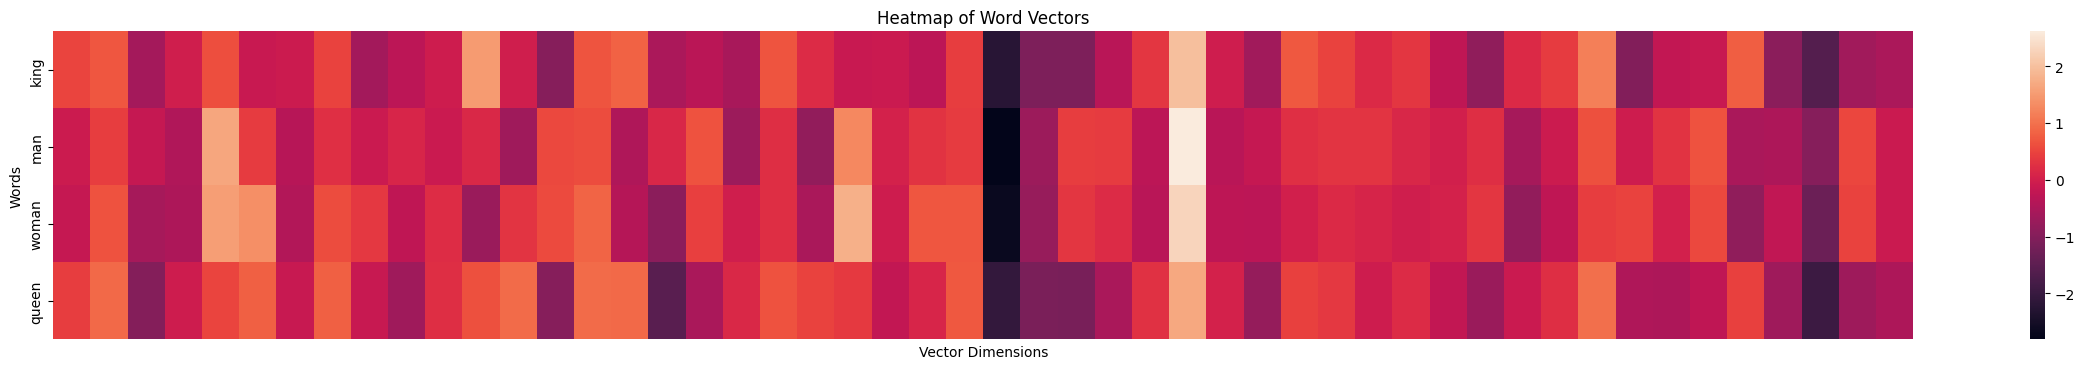

In [44]:
import seaborn as sns

vectors = np.array([king_vector, man_vector, woman_vector, queen_vector])
labels = ['king', 'man', 'woman', 'queen']

# Визуализация векторов в виде тепловой карты
plt.figure(figsize=(30, 4))
sns.heatmap(vectors, annot=False, xticklabels=False, yticklabels=labels)
plt.title('Heatmap of Word Vectors')
plt.xlabel('Vector Dimensions')
plt.ylabel('Words')
plt.show()

## Word2Vec

**Word2Vec** - это метод векторного представления слов, который строит эмбеддинги слов на основе их контекста. Модель пытается уловить смысл слов, основываясь на том, что слова с похожим контекстом имеют схожие векторы.

Существует два основных подхода в Word2Vec: Continuous Bag of Words (CBOW) и Skip-gram. В CBOW модель предсказывает целевое слово по контексту (несколько слов, стоящих рядом). Skip-gram работает наоборот, и модель предсказывает контекст по центральному слову.

 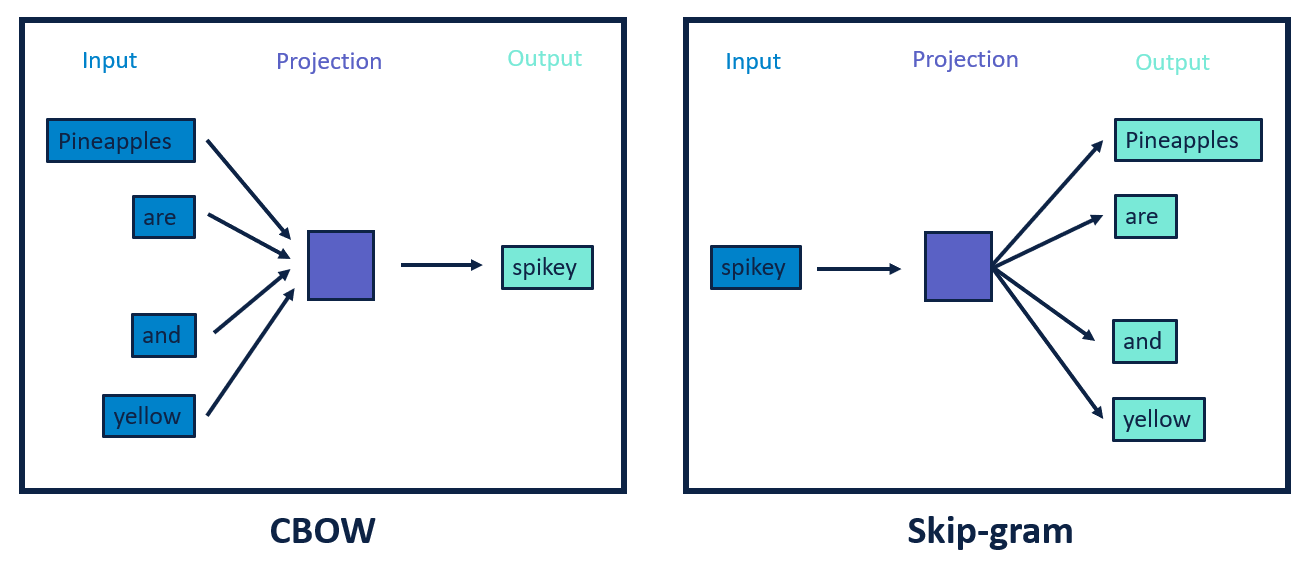

### Дополнительные ресурсы:

* [Оригинальная статья Mikolov et al.](https://arxiv.org/abs/1301.3781)
* [Туториал по использованию Word2Vec в Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)
* [Большой туториал по Word2Vec](https://habr.com/ru/articles/446530/)

Word2Vec уже полностью реализован в библиотеке `Gensim`. В ней же находятся и много других моделей

[Официальная документация Gensim](https://radimrehurek.com/gensim/)

Обучим Word2Vec на полном наборе данных. При этом исключим из него все строчки из тестовой выборки X_test.

Класс `Word2Vec` принимает несколько аргументов:

- *sentences: массив с текстами. При этом они должны быть разбиты на токены*
- *vector_size: размер векторного представления*
- *window: размер окна контекста*

In [45]:
from gensim.models import Word2Vec

# Выбираем все изначальные данные, за исключениям строк из X_test
train_data = df[~df.index.isin(X_test.index)]['lemmas']

# Массив с предложениями для обучения
tokenized_texts = [word_tokenize(sentence) for sentence in train_data]

embedding_dim = 300 # Размерность эмбеддинга
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=embedding_dim, window=5, seed=42, workers=1)

Посмотрим на результат, обратившись к методу `wv.get_vector()`

In [46]:
word2vec_model.wv.get_vector('праздник')[:10]

array([-0.3681716 , -0.21122515,  0.2867301 ,  0.12265631,  0.3264001 ,
       -0.22195241,  0.17915069, -0.39804882, -0.83623934, -0.55224735],
      dtype=float32)

300 цифр не могут нам ни о чем сказать. В `gensim` есть метод для просмотра самых близких слов по векторным представлениям.

In [47]:
word2vec_model.wv.most_similar('праздник', topn=10)

[('рождество', 0.8315292596817017),
 ('отдых', 0.7970376014709473),
 ('выходной', 0.7926563024520874),
 ('декабрь', 0.7892035245895386),
 ('каникулы', 0.7701753377914429),
 ('выходные', 0.7664746642112732),
 ('концу', 0.7608545422554016),
 ('встреча', 0.7579447627067566),
 ('зимний', 0.7569475769996643),
 ('праздничный', 0.7563626766204834)]

Попробуем построить логистическую регрессию по векторным представлениям. Если мы представим эмбеддинги слов в качестве столбцов, то получится таблица с $300\times30 = 9000$ колонками(это при условии, что длина предложений 30). Чтобы избежать огромной размерности, мы будем просто брать средние значения по векторному представлению слова. При этом нужно еще ограничить максимальную длину. Техника ограничения длины повсеместно применяется для нейросетей. Если длина предложения меньше заданного ограничения, то к нему добавляется специальный токен - **padding**.

 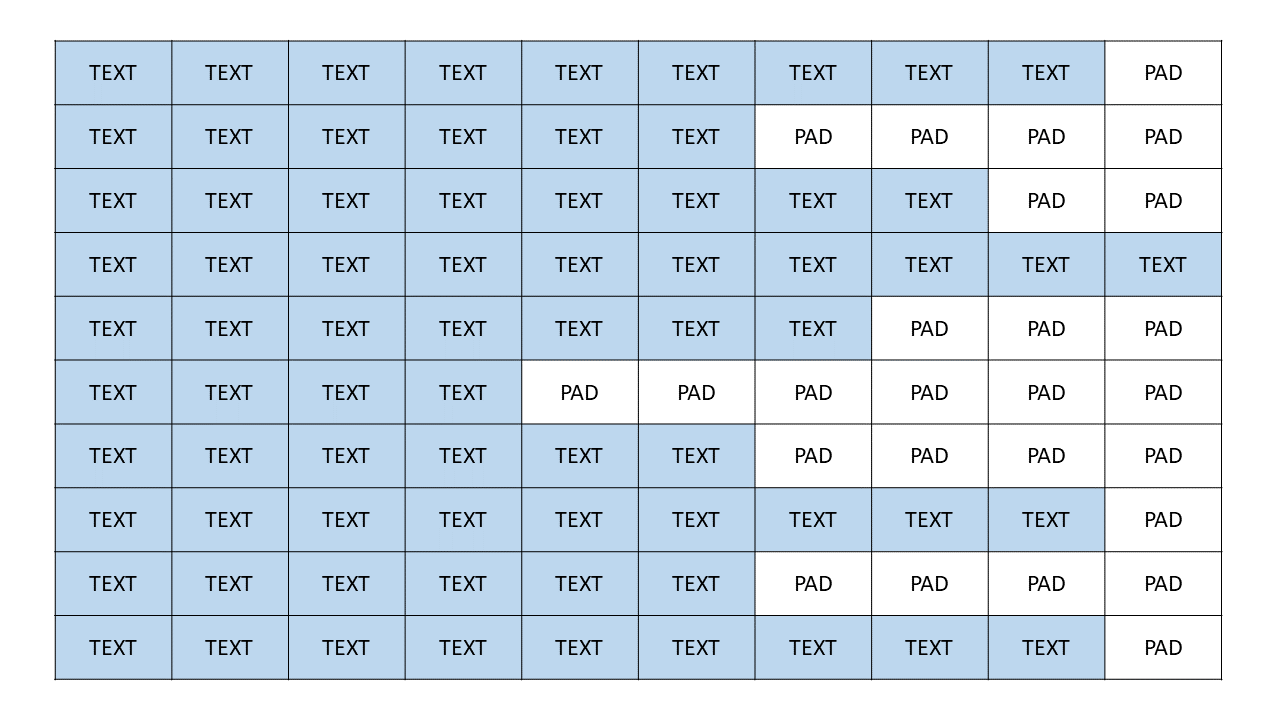

Создадим вспомогательную функцию, которая будет ограничивать максимальную длину, получать векторные представления для слов и брать среднее от них

In [48]:
def process_sentences_with_embeddings(senteces, max_length, embedding_model,
                                      embedding_dim, mean=True):
    embeddings_list = []

    for sentence in tqdm(senteces):
        tokens = word_tokenize(sentence) # Получает токены

        embeddings = []
        for token in tokens[:max_length]:
            if token in embedding_model.wv: # Проверяем, есть ли в нашей модели вектор для слова
                embedding = embedding_model.wv[token]
                embeddings.append(embedding)

        # Если ни одного слова не нашлось, возвращаем нулевой вектор
        if len(embeddings) == 0:
            embeddings = np.zeros((max_length, embedding_dim))

        if mean:
            embeddings_list.append(np.mean(np.array(embeddings), axis=0))
        else:
            count_of_adding = max(0, max_length - len(tokens))
            embeddings.extend([np.zeros(embedding_dim)] * count_of_adding)
            embeddings_list.append(embeddings[:max_length])

    return np.stack(embeddings_list)

Применим функцию для наших данных, ограничив **максимальную длину последовательности** размером 20 токенов.



In [49]:
max_length = 20

X_train_processed = process_sentences_with_embeddings(X_train, max_length, word2vec_model, embedding_dim)
X_test_processed = process_sentences_with_embeddings(X_test, max_length, word2vec_model, embedding_dim)

  0%|          | 0/26800 [00:00<?, ?it/s]

  0%|          | 0/13200 [00:00<?, ?it/s]

In [50]:
X_train_processed.shape

(26800, 300)

In [51]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_processed, y_train)

LogisticRegression(random_state=42)

In [52]:
pred = clf.predict(X_test_processed)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.99      0.98      0.99      6452
    positive       0.98      0.99      0.99      6748

    accuracy                           0.99     13200
   macro avg       0.99      0.99      0.99     13200
weighted avg       0.99      0.99      0.99     13200



Получилось очень хорошее качество. Теперь попробуем через FastText

## Fasttext

FastText использует не только эмбеддинги слов, но и эмбеддинги n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм.

Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграмм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова).

Благодаря этому мы можем также получать вектора для слов, отсутствующих в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

FastText также может использовать подходы CBOW или Skip-gram для построения эмбеддингов

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [FastText в Gensim](https://radimrehurek.com/gensim/models/fasttext.html)


У gensim есть альтернатива - библиотека `fasttext`

In [53]:
from gensim.models import FastText

# Выбираем все изначальные данные, за исключениям строк из X_test
train_data = df[~df.index.isin(X_test.index)]['lemmas']

# Массив с предложениями для обучения
tokenized_texts = [word_tokenize(sentence) for sentence in train_data]

embedding_dim = 300 # Размерность эмбеддинга
fasttext_model = FastText(sentences=tokenized_texts, vector_size=embedding_dim, window=5, seed=42, workers=1)

### Задание 3: Ближайшие вектора

Посмотрите какие 10 векторных представлений ближе всего к слову 'праздник'. Отличается ли результат от Word2Vec?


Это задание можно решить при помощи [Giga Chat](https://giga.chat/gigachat/), самостоятельно придумав промпт, либо самому без помощи языковых моделей. Если используете промпт, обязательно укажите, что берете модель из библиотеки gensim.

In [ ]:
### Ваш код ###
fasttext_model.most_similar('лук', topn=10)

Обучим логистическую регрессию на средних значениях эмбеддингов:

In [ ]:
max_length = 20

X_train_processed = process_sentences_with_embeddings(X_train, max_length, fasttext_model, embedding_dim)
X_test_processed = process_sentences_with_embeddings(X_test, max_length, fasttext_model, embedding_dim)

  0%|          | 0/26800 [00:00<?, ?it/s]

  0%|          | 0/13200 [00:00<?, ?it/s]

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_processed, y_train)

pred = clf.predict(X_test_processed)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.99      0.98      0.99      6452
    positive       0.99      0.99      0.99      6748

    accuracy                           0.99     13200
   macro avg       0.99      0.99      0.99     13200
weighted avg       0.99      0.99      0.99     13200



## Бонус: модель LSTM

In [54]:
import torch

### Подготовка данных для нейронных сетей

В этом блоке мы рассмотрим, как применять рекуррентные нейронные сети для решения задачи классификации, в частности сентимент анализа. Для этого мы будем использовать библиотеку `Pytorch`.

Мы уже обучили Word2Vec и FastText и можем получить эмбеддинги для слов. Возьмем векторные представления из второй модели. Мы уже создали функцию, которая делает наши предложения одинаковой длины. Осталось привести наши `y` в формат 0, 1, так как модели не могут работать с именами классов напрямую.

In [55]:
y_train.head()

,label
68370,positive
221887,negative
97663,positive
212275,negative
17846,positive


In [56]:
y_train_encoded = [1 if element == 'positive' else 0 for element in y_train]
y_test_encoded = [1 if element == 'positive' else 0 for element in y_test]

Теперь еще раз применим функцию для получения эмбеддингов. Только теперь будем брать весь вектор, а не среднее. В качестве модели используем FastText

In [57]:
max_length = 20

X_train_processed = process_sentences_with_embeddings(X_train, max_length, fasttext_model, embedding_dim, mean=False)
X_test_processed = process_sentences_with_embeddings(X_test, max_length, fasttext_model, embedding_dim, mean=False)

  0%|          | 0/26800 [00:00<?, ?it/s]

  0%|          | 0/13200 [00:00<?, ?it/s]

In [58]:
X_test_processed.shape

(13200, 20, 300)

Преобразуем получившиеся значения в тензоры

In [59]:
# Определяем девайс(видеокарта или процессор)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_processed = torch.FloatTensor(X_train_processed).to(device)
X_test_processed = torch.FloatTensor(X_test_processed).to(device)

y_train_encoded = torch.FloatTensor(y_train_encoded).to(device)
y_test_encoded = torch.FloatTensor(y_test_encoded).to(device)

Создадим `dataset` и `dataloader` из `torch`

In [60]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512
torch.manual_seed(42)

train_dataset = TensorDataset(X_train_processed, y_train_encoded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_processed, y_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Создание модели

Наша нейронная сеть для классификации текстов будет состоять из **LSTM** слоев с рекуррентными нейронами.

**RNN** (рекуррентные нейронные сети) - это тип нейронных сетей, которые обрабатывают последовательные данные, например текст или временные ряды. Они состоят из повторяющихся модулей (рекуррентных нейронов), которые получают на вход текущий элемент последовательности и скрытое состояние (один эмбеддинг), отражающее предыдущий контекст. Скрытое состояние представляет собой аналог памяти, так как его эмбеддинг содержит информацию о последних обработанных словах. Выходом **RNN** является новое скрытое состояние, которое может использоваться для дальнейшей обработки.


 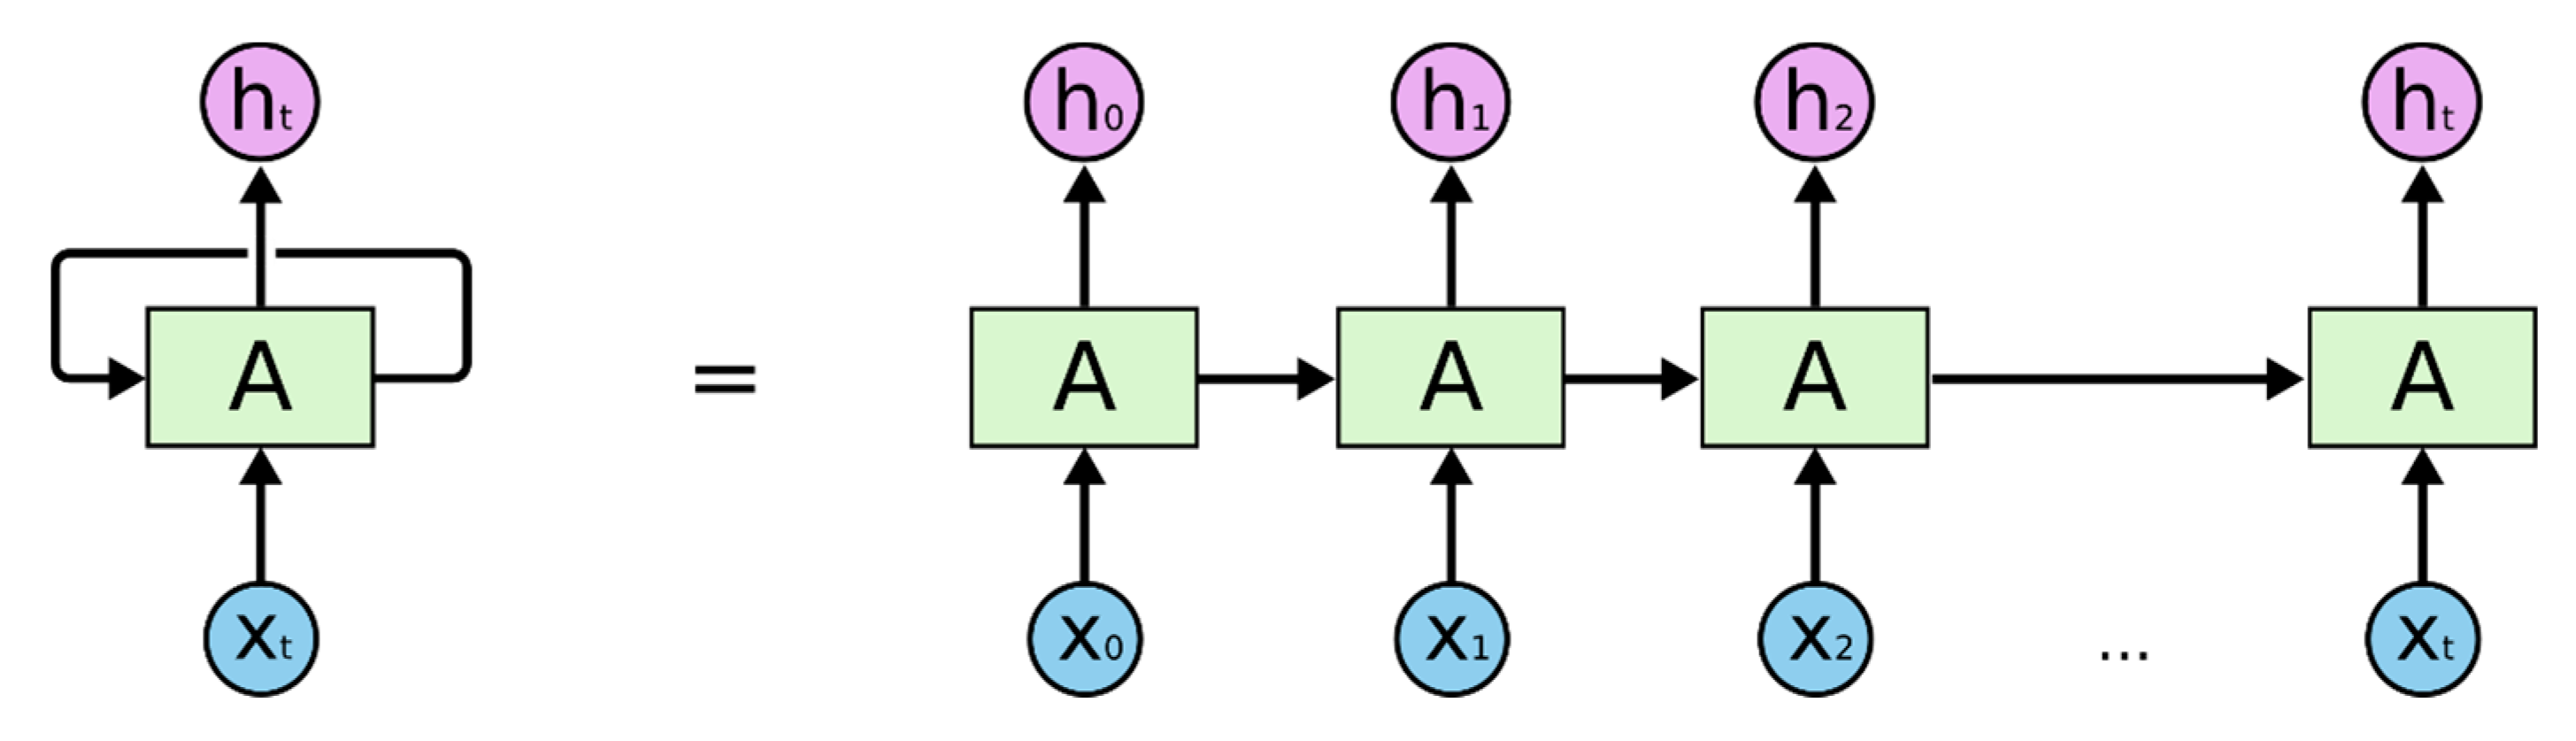

У **RNN** есть особенность - их последовательная архитектура, из-за которой информация о первых токенах в последовательности может "теряться" по мере увеличения длины обрабатываемой последовательности. Данная проблема называется затуханием градиента. **LSTM** пытается решить эту проблему с помощью специальных частей, учащихся запоминать или удалять информацию.

**LSTM** имеет дополнительную ячейку памяти, которая хранит долгосрочную информацию о последовательности. Отдельный нейрон регулируют поток информации в ячейку памяти, решая, что нужно сохранить или забыть. Таким образом, **LSTM** может изучать долгосрочные зависимости и избегать проблем с градиентами.

 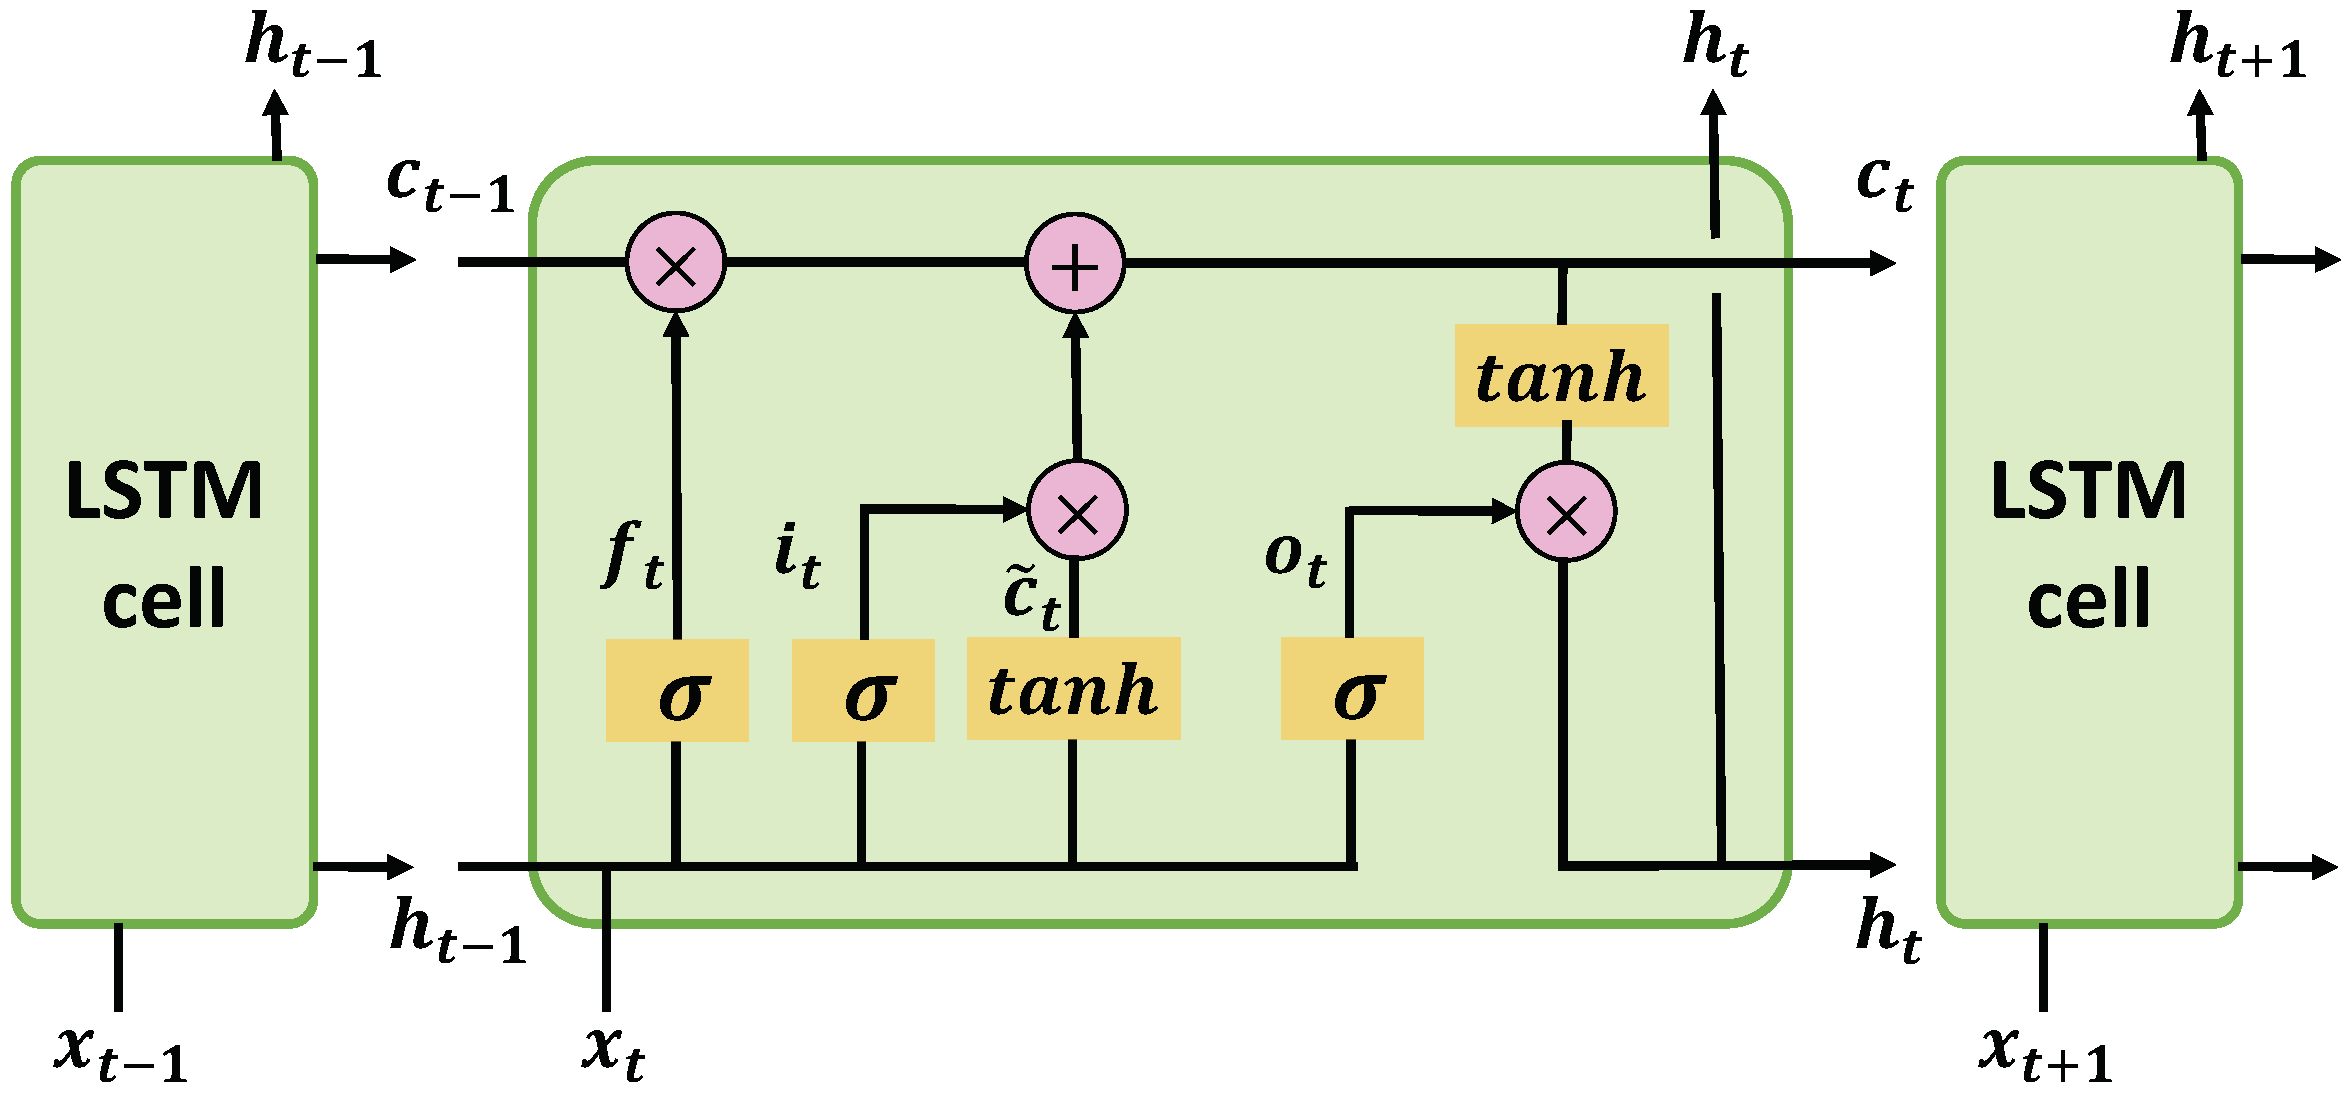

В `Pytorch` уже реализован блок **LSTM**. У него есть несколько основных аргументов:

- *input_size: размерность эмбеддинга*
- *hidden_size: размерность скрытого состояния*
- *num_layers: количество повторяющихся слоев. В данном случае слои обозначают уровни **LSTM**. В случае 2 уровней нашу последовательность сначала обработают одни **LSTM** блоки, а затем вторые, которые будут уже принимать скрытые состояния предыдущих.*

Мы используем одинаковую размерность input_size и hidden_size.

In [61]:
from torch import nn

class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, output_size):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
            )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        output = self.sigmoid(output)
        return output

hidden_size = embedding_dim
num_layers = 2
output_size = 1

model = LSTMClassifier(hidden_size, num_layers, output_size).to(device)

### Обучение **LSTM**

In [62]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

In [63]:
# Функция обучения одной эпохи
def train_step(model, train_dataloader, optimizer):

    model.train() # Переводим модель в режим тренировки

    # Сохраняем различные статистики внутри эпохи
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Итерация по батчам в датасете
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Обнуление градиентов.
        # Без данной строчки, торч просто добавит их к предыдущим
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs) # Передаем текстовые данные в модель
        loss = criterion(outputs, labels.unsqueeze(1).float()) # Считаем функцию потерь
        loss.backward() # Применяем обратное распространение ошибки
        optimizer.step() # Делаем шаг обучения

        # Статистика для вывода
        running_loss += loss.item()
        predicted = (outputs.data.squeeze(1) > 0.5).int()
        total_samples += labels.size(0)

        correct_predictions += (predicted == labels).sum().item()

    # Вычисление среднего значения потерь и точности на эпохе
    train_accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(train_dataloader)

    return average_loss, train_accuracy

def test_step(model, test_dataloader):
    # Часть для тестирования на test выборке
    model.eval()

    # Статистика для тестирования
    test_correct_predictions = 0
    test_total_samples = 0

    # Итерация по батчам в валидационном датасете
    with torch.no_grad():  # Не считаем градиенты, так как это тестирование
        for i, data in enumerate(test_dataloader):
            inputs, labels = data

            # Прямой проход
            outputs = model(inputs)

            # Статистика для вывода
            predicted = (outputs.data.squeeze(1) > 0.5).int()
            test_total_samples += labels.size(0)
            test_correct_predictions += (predicted == labels).sum().item()

    # Вычисление точности на тестовой выборке
    test_accuracy = test_correct_predictions / test_total_samples
    return test_accuracy


# Общая функция для обучения
def train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs=8):
    #Будем складывать accuracy на каждой эпохе
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs): # Итерируемся по эпохам
        # Шаг обучения
        average_loss, train_accuracy = train_step(model, train_dataloader, optimizer)
        train_accuracy_history.append(train_accuracy)

        # Шаг тестирования
        test_accuracy = test_step(model, test_dataloader)
        test_accuracy_history.append(test_accuracy)

        # Вывод результатов
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Loss: {average_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}')

    return train_accuracy_history, test_accuracy_history

In [64]:
train_accuracy_history, test_accuracy_history = train_model(model, train_loader, test_loader, optimizer, num_epochs)

Epoch 1/10
Loss: 0.4349 | Train Accuracy: 0.8332 | Test Accuracy: 0.9742


KeyboardInterrupt: 

Вы можете попробовать поменять архитектуру нейронной сети и параметры, чтобы добиться более высоких результатов:)

## О важности эксплоративного анализа

Иногда пунктуация бывает и не шумом - главное отталкиваться от задачи. Что будет, если вообще не убирать пунктуацию?

In [65]:
# Создаем новый векторайзер
alternative_count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                               tokenizer=word_tokenize)

# Обучаем его и сразу применяем к x_train
alternative_count_vectorized_x_train = alternative_count_vectorizer.fit_transform(X_train)

# Инициализируем и обучаем классификатор
clf = LogisticRegression(random_state=42)
clf.fit(alternative_count_vectorized_x_train, y_train)

# Применяем обученный векторайзер к тестовым данным
alternative_count_vectorized_x_test = alternative_count_vectorizer.transform(X_test)

# Получаем предсказания и выводим информацию о качестве
pred = clf.predict(alternative_count_vectorized_x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       1.00      0.99      1.00      6452
    positive       0.99      1.00      1.00      6748

    accuracy                           1.00     13200
   macro avg       1.00      1.00      1.00     13200
weighted avg       1.00      1.00      1.00     13200



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди нее были очень значимые токены (как вы думаете, какие?). Найдем признаки с самыми большими коэффициентами:

In [66]:
tokens = alternative_count_vectorizer.get_feature_names_out()
weights = clf.coef_[0]
dict_tokens_weights = dict(zip(tokens, weights))

best_tokens = sorted(dict_tokens_weights.items(), key=lambda item: item[1], reverse=True)
best_tokens[:10]

[(')', 7.6162660373338715),
 ('d', 4.274988044031438),
 ('^_^', 3.4263326911956913),
 ('dd', 2.568205791472402),
 ('ddd', 1.9729876890112872),
 (':', 1.9138964585921006),
 ('dddd', 1.2713269222156858),
 ('любить', 1.0227981616789372),
 ('хочупровестиновогоднююночьвместёс', 0.9797376164245936),
 ('спасибо', 0.9525863919971279)]

**Вопрос**: Как думаете, почему токен "хочупровестиновогоднююночьвместёс" оказался среди важных?

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [67]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in X_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92      7601
    positive       0.83      1.00      0.91      5599

    accuracy                           0.91     13200
   macro avg       0.91      0.92      0.91     13200
weighted avg       0.93      0.91      0.91     13200



# Выводы

1. Мы подгрузили данные твитов для определения их сентимента

2. Мы познакомились со **стоп-словами** и попытались очистить текст

3. Мы узнали, что такое **лемматизация** и с помощью каких библиотек ее можно применять

4. Мы научились **токенизировать** данные

5. Мы **обучили модель** машинного обучения для классификации текстов

6. Мы познакомились с **эмбеддингами** слов